In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')


df = pd.read_csv('students_simple.csv')


N = 24

col1_index = N % 5
col2_index = (N**2) % 5 + 5

columns = df.columns.tolist()
x_col = columns[col1_index]
y_col = columns[col2_index]

print(f"Выбранные столбцы: {x_col} (X) и {y_col} (Y)")

Выбранные столбцы: pages (X) и bmi (Y)


In [15]:
x = df[x_col].dropna()
y = df[y_col].dropna()

min_len = min(len(x), len(y))
x = x.iloc[:min_len]
y = y.iloc[:min_len]

def fechner_correlation(x, y):
    x_med = np.median(x)
    y_med = np.median(y)
    signs = np.sign((x - x_med) * (y - y_med))
    C = np.sum(signs == 1)
    H = len(x)
    return (2 * C - H) / H

r_fechner = fechner_correlation(x, y)

r_pearson, p_pearson = stats.pearsonr(x, y)
n = len(x)
z = np.arctanh(r_pearson)
se = 1 / np.sqrt(n - 3)
z_crit = stats.norm.ppf(0.975)
ci_low, ci_high = np.tanh(z - z_crit * se), np.tanh(z + z_crit * se)

r_spearman, p_spearman = stats.spearmanr(x, y)

r_kendall, p_kendall = stats.kendalltau(x, y)

print(f"Коэффициент Фехнера: {r_fechner:.4f}")
print(f"Пирсон: {r_pearson:.4f} (95% CI: [{ci_low:.4f}, {ci_high:.4f}])")
print(f"Спирмен: {r_spearman:.4f}")
print(f"Кенделл: {r_kendall:.4f}")

Коэффициент Фехнера: -0.4000
Пирсон: -0.1795 (95% CI: [-0.5762, 0.2857])
Спирмен: -0.3239
Кенделл: -0.2442


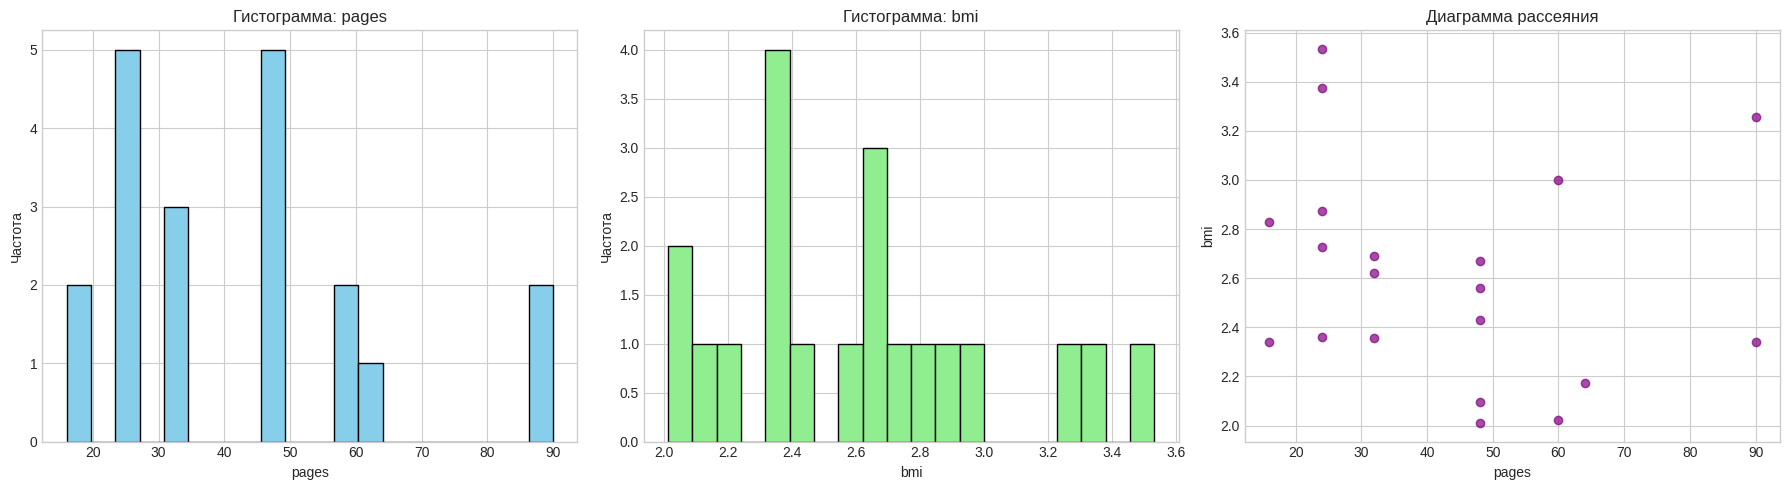

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].hist(x, bins=20, color='skyblue', edgecolor='black')
axes[0].set_title(f'Гистограмма: {x_col}')
axes[0].set_xlabel(x_col)
axes[0].set_ylabel('Частота')

axes[1].hist(y, bins=20, color='lightgreen', edgecolor='black')
axes[1].set_title(f'Гистограмма: {y_col}')
axes[1].set_xlabel(y_col)
axes[1].set_ylabel('Частота')

axes[2].scatter(x, y, alpha=0.7, color='purple')
axes[2].set_xlabel(x_col)
axes[2].set_ylabel(y_col)
axes[2].set_title('Диаграмма рассеяния')

plt.tight_layout()
plt.show()

In [24]:
x_vals = np.array(x)
y_vals = np.array(y)

# 1. Линейная: y = w1*x + w0
coef_lin = np.polyfit(x_vals, y_vals, 1)
y_lin = np.polyval(coef_lin, x_vals)

# 2. Квадратичная: y = w2*x^2 + w1*x + w0
coef_quad = np.polyfit(x_vals, y_vals, 2)
y_quad = np.polyval(coef_quad, x_vals)

# 3. Гиперболическая: y = w1 / x + w0
def hyperbola(x, w1, w0):
    return w1 / x + w0

# Исключаем x=0 (хотя в наших данных x = pages ≥ 16)
try:
    popt_hyp, _ = curve_fit(hyperbola, x_vals, y_vals, maxfev=10000)
    y_hyp = hyperbola(x_vals, *popt_hyp)
except Exception as e:
    y_hyp = np.full_like(x_vals, np.nan)
    print(f"Гиперболическая модель не сошлась: {e}")

# 4. Показательная: y = a * exp(b * x)
# Используем устойчивую линеаризацию через логарифмирование (только если y > 0)
if np.all(y_vals > 0):
    log_y = np.log(y_vals)
    try:
        # Линейная регрессия: log(y) = ln(a) + b * x
        b, ln_a = np.polyfit(x_vals, log_y, 1)  # [b, ln(a)]
        a = np.exp(ln_a)
        y_exp = a * np.exp(b * x_vals)
    except Exception as e:
        y_exp = np.full_like(x_vals, np.nan)
        print(f"Показательная модель (линеаризация) не сошлась: {e}")
else:
    y_exp = np.full_like(x_vals, np.nan)
    print("Показательная модель невозможна: y содержит неположительные значения")

# R^2 для каждой модели
models = {
    'Линейная': y_lin,
    'Квадратичная': y_quad,
    'Гиперболическая': y_hyp,
    'Показательная': y_exp
}

r2_scores = {}
for name, y_pred in models.items():
    if np.all(np.isfinite(y_pred)):
        r2 = r2_score(y_vals, y_pred)
    else:
        r2 = -np.inf  # недопустимая модель
    r2_scores[name] = r2

# Сортировка по R^2
best_model = max(r2_scores, key=r2_scores.get)
worst_model = min(r2_scores, key=r2_scores.get)

print("Коэффициенты детерминации (R²):")
for name, r2 in r2_scores.items():
    if r2 == -np.inf:
        print(f"  {name}: недопустима")
    else:
        print(f"  {name}: {r2:.4f}")
print(f"\nЛучшая модель: {best_model}")
print(f"Худшая модель: {worst_model}")

Коэффициенты детерминации (R²):
  Линейная: 0.0322
  Квадратичная: 0.1830
  Гиперболическая: 0.0670
  Показательная: 0.0289

Лучшая модель: Квадратичная
Худшая модель: Показательная


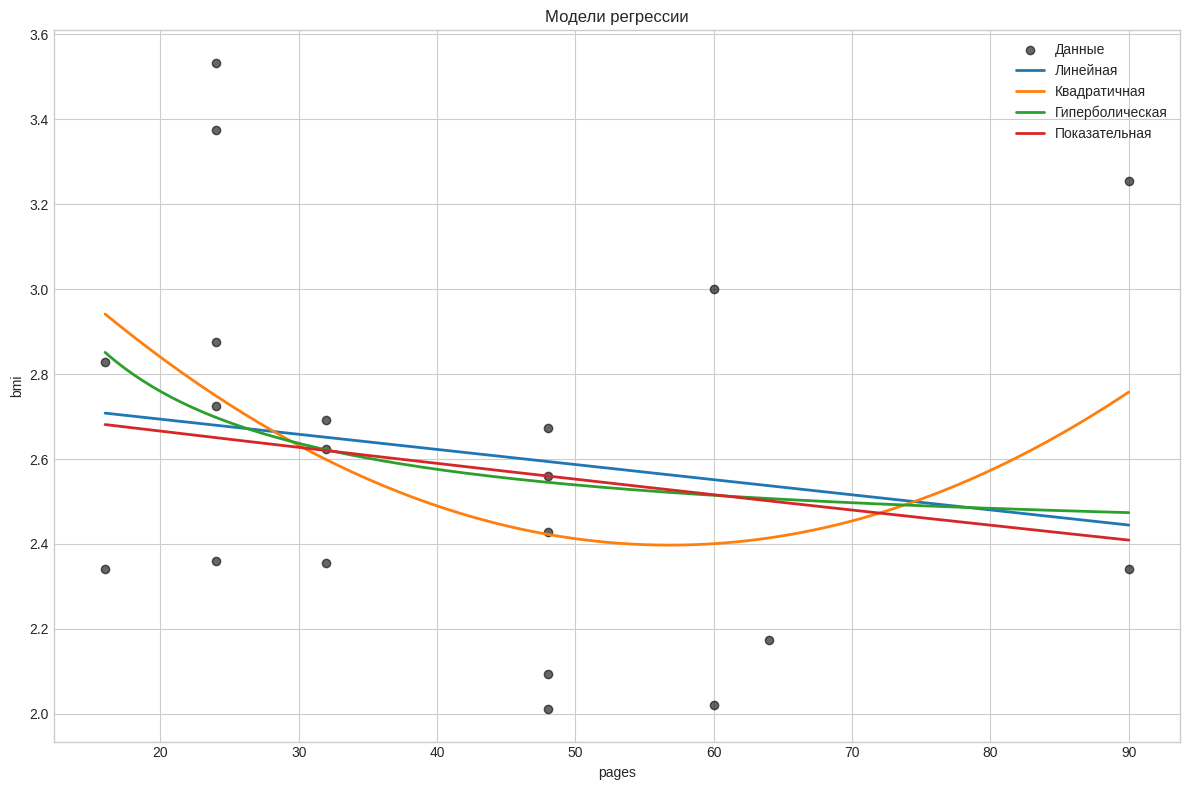

In [27]:
x_plot = np.linspace(x_vals.min(), x_vals.max(), 200)

plt.figure(figsize=(12, 8))
plt.scatter(x_vals, y_vals, label='Данные', color='black', alpha=0.6)

# Линейная
y_plot_lin = np.polyval(coef_lin, x_plot)
plt.plot(x_plot, y_plot_lin, label='Линейная', linewidth=2)

# Квадратичная
y_plot_quad = np.polyval(coef_quad, x_plot)
plt.plot(x_plot, y_plot_quad, label='Квадратичная', linewidth=2)

# Гиперболическая — проверяем, была ли она успешно рассчитана
if 'y_hyp' in locals() and np.all(np.isfinite(y_hyp)):
    # Используем уже найденные параметры popt_hyp
    try:
        y_plot_hyp = hyperbola(x_plot, *popt_hyp)
        if np.all(np.isfinite(y_plot_hyp)):
            plt.plot(x_plot, y_plot_hyp, label='Гиперболическая', linewidth=2)
    except:
        pass  # если ошибка при расчёте на сетке — пропускаем

# Показательная — строим через параметры a и b из линеаризации
if 'a' in locals() and 'b' in locals():
    try:
        y_plot_exp = a * np.exp(b * x_plot)
        if np.all(np.isfinite(y_plot_exp)):
            plt.plot(x_plot, y_plot_exp, label='Показательная', linewidth=2)
    except:
        pass

plt.xlabel(x_col)
plt.ylabel(y_col)
plt.legend()
plt.title('Модели регрессии')
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
def f_test(y_true, y_pred, p):
    """
    y_true — истинные значения
    y_pred — предсказанные
    p — число параметров модели (включая константу)
    """
    n = len(y_true)
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - ss_res / ss_tot
    if r2 == 1:
        return np.inf, 0.0
    f_stat = (r2 / (p - 1)) / ((1 - r2) / (n - p))
    p_value = 1 - stats.f.cdf(f_stat, p - 1, n - p)
    return f_stat, p_value

# Определяем число параметров
params = {
    'Линейная': 2,
    'Квадратичная': 3,
    'Гиперболическая': 2,
    'Показательная': 2
}

# Лучшая модель
y_best = models[best_model]
p_best = params[best_model]
f_best, pval_best = f_test(y_vals, y_best, p_best)

# Худшая модель
y_worst = models[worst_model]
p_worst = params[worst_model]
f_worst, pval_worst = f_test(y_vals, y_worst, p_worst)

print(f"Критерий Фишера для лучшей модели ({best_model}):")
print(f"  F = {f_best:.4f}, p-value = {pval_best:.4e}")
print(f"Критерий Фишера для худшей модели ({worst_model}):")
print(f"  F = {f_worst:.4f}, p-value = {pval_worst:.4e}")

alpha = 0.05
if pval_best < alpha:
    print(f"\n✅ Лучшая модель значима (p < {alpha})")
else:
    print(f"\n❌ Лучшая модель НЕ значима")

if pval_worst < alpha:
    print(f"✅ Худшая модель значима (p < {alpha})")
else:
    print(f"❌ Худшая модель НЕ значима")

Критерий Фишера для лучшей модели (Квадратичная):
  F = 1.9036, p-value = 1.7947e-01
Критерий Фишера для худшей модели (Показательная):
  F = 0.5358, p-value = 4.7360e-01

❌ Лучшая модель НЕ значима
❌ Худшая модель НЕ значима
